In [1]:
import numpy as np
np.random.seed(1001)

import os
import sys
import shutil

import IPython
import IPython.display as ipd  # To play sound in the notebook

import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
# from tqdm import tqdm_notebook, tqdm
import tqdm

import librosa 
import librosa.display

import wave
from sklearn.preprocessing import StandardScaler

import torch 
import torchaudio
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataset import random_split

from torchvision import transforms, utils

from torch import autograd
from torch.autograd import Variable
import torch.nn.functional as F
from torch.nn import ModuleList
from torch.nn import Linear, ReLU, LeakyReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, AdaptiveMaxPool2d
from torch.nn import Softmax, LogSoftmax, Tanh, BatchNorm1d, BatchNorm2d, Dropout, Flatten, GRU, Sigmoid
from torch.nn import CrossEntropyLoss, NLLLoss, BCEWithLogitsLoss, BCELoss, CTCLoss
from torch.optim import Adam, SGD

from torch.utils.tensorboard import SummaryWriter
import sed_metrics

dataset_path = '/home/renault/Projects/Statet-of-the-Art/Dataset/TUT-SED-2016/'
new_sample_rate = 44100
n_fft = 2048
hop_len = int(n_fft/2)
n_mels = 40
frames_1_sec = int(new_sample_rate/(n_fft/2.0))

/home/renault/env/lib/python3.5/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/renault/env/lib/python3.5/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/renault/env/lib/python3.5/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/renault/env/lib/python3.5/site-packages/tensorboard/compat/tensorflow_

# 1. Load waveform and export spectrogram features

In [2]:
filename = "audio/home/a030.wav"
def extract_audio_features(filename, verbose=False):
    new_sample_rate = 44100
    n_fft = 2048
    hop_length = int(n_fft/2)
    n_mels = 40
#     scaler = StandardScaler()

    waveform, sample_rate = librosa.load(dataset_path + filename,mono=True)
    resampled_waveform = librosa.core.resample(waveform, sample_rate, new_sample_rate)
    S = librosa.feature.melspectrogram(y=resampled_waveform, 
                                       sr=new_sample_rate, 
                                       n_mels=n_mels,
                                       n_fft= n_fft,
                                       hop_length=hop_length,
                                       center=False,
                                       power=1.0)
    S_dB = librosa.amplitude_to_db(S)
#     S_dB = scaler.fit_transform(S_dB)
    
    if verbose:
        print("Shape of feature: ", S_dB.shape)

        plt.figure(figsize=(14,5))
        librosa.display.waveplot(y=resampled_waveform, sr=new_sample_rate)
        plt.title("Resampled waveform of audio file")
        plt.show()
        plt.figure(figsize=(14, 5))
        librosa.display.specshow(S_dB,sr=new_sample_rate, hop_length=hop_length,
                                x_axis='time', y_axis='mel')
        plt.title("Log Mel Energy")
        plt.show()
    
    return S_dB.T

Shape of feature:  (40, 7779)


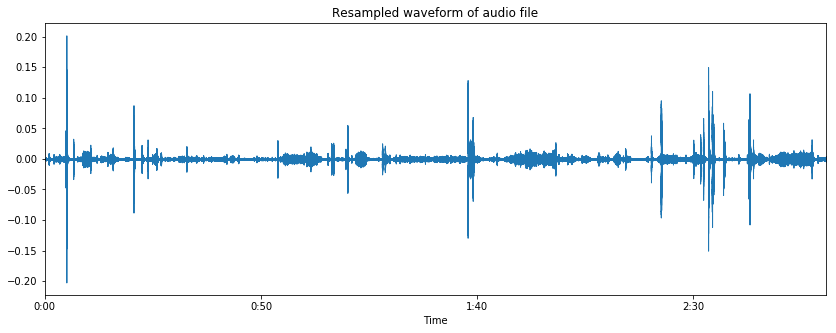

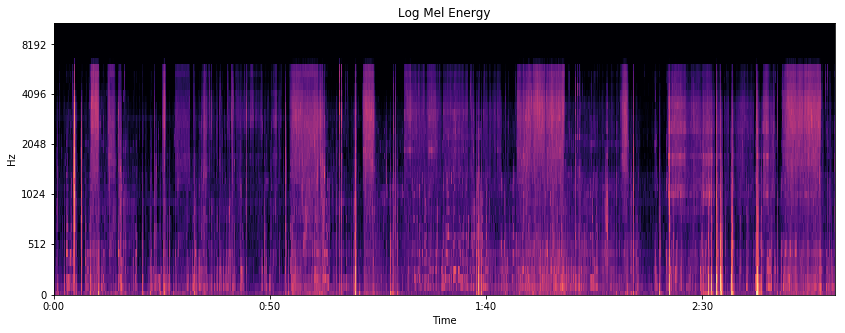

In [57]:
filename = "audio/home/a031.wav"
_ = extract_audio_features(filename,True)

Shape of feature:  (40, 12956)


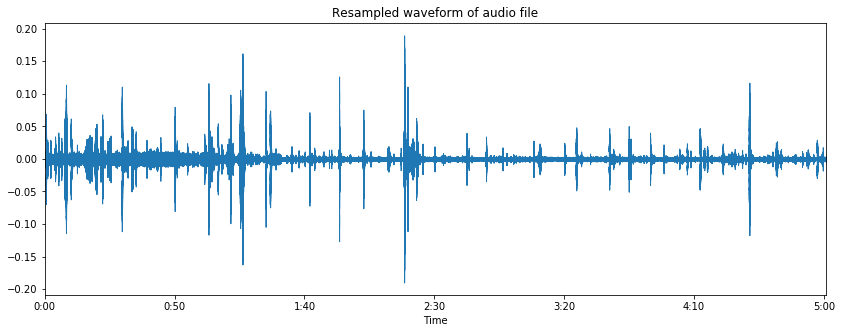

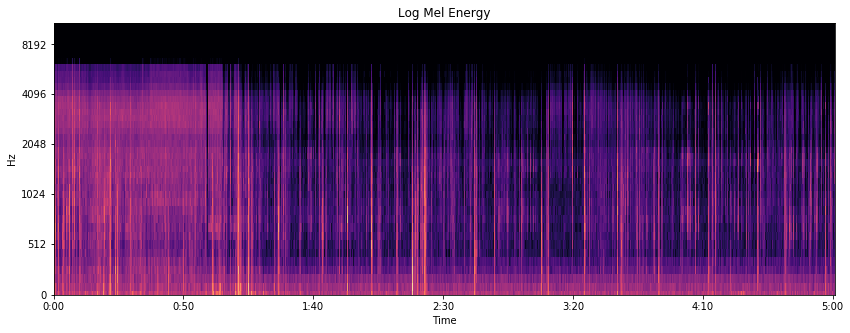

In [29]:
filename = "audio/home/b032.wav"
_ = extract_audio_features(filename,True)

Shape of feature:  (40, 9084)


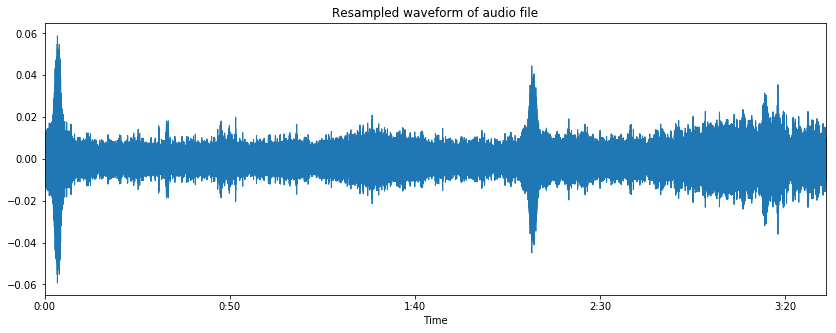

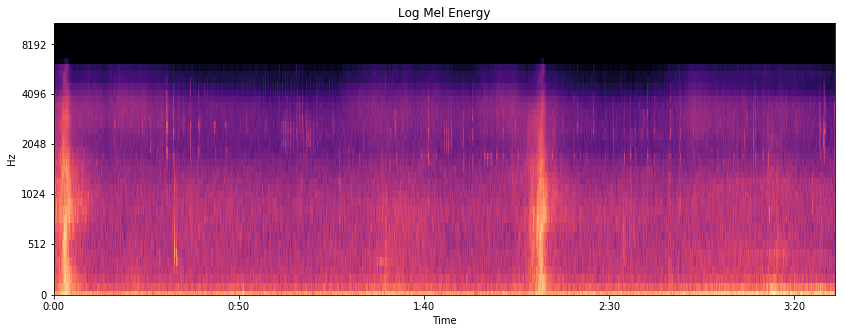

In [59]:
filename = "audio/residential_area/a010.wav"
_ = extract_audio_features(filename,True)

Shape of feature:  (40, 8493)


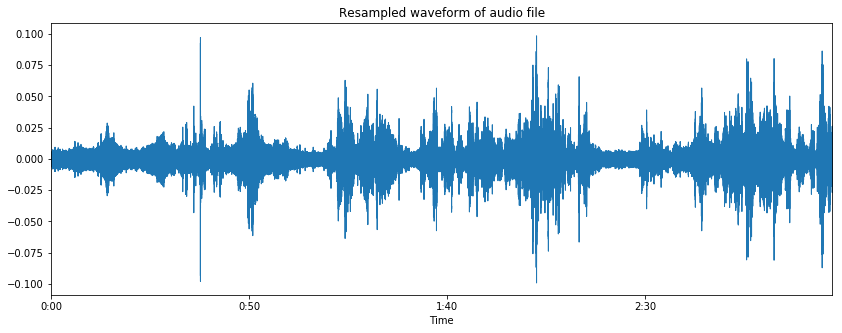

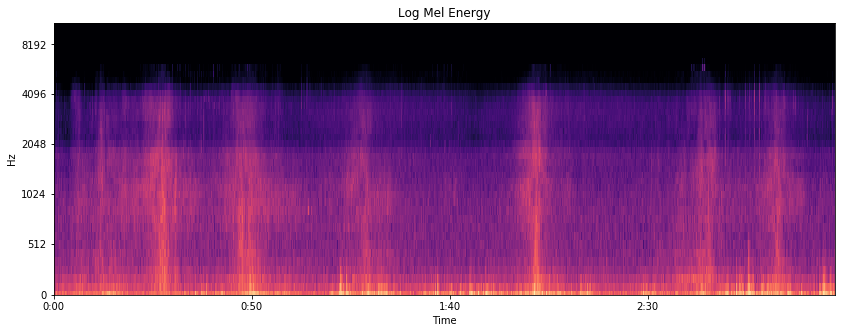

In [32]:
filename = "audio/residential_area/b002.wav"
_ = extract_audio_features(filename,True)

# 2. Load description file

In [3]:
# desc_file = dataset_path + "evaluation_setup/home_fold1_train.txt"
__class_labels = {
    '(object) rustling' : 0,
    '(object) snapping' : 1,
    'cupboard'          : 2,
    'cutlery'           : 3,
    'dishes'            : 4,
    'drawer'            : 5,
    'glass jingling'    : 6,
    'object impact'     : 7,
    'people walking'    : 8,
    'washing dishes'    : 9,
    'water tap running' : 10,
    '(object) banging'  : 11,
    'bird singing'      : 12,
    'car passing by'    : 13,
    'children shouting' : 14,
    'people speaking'   : 15,
    'wind blowing'      : 16,
}


def load_desc(desc_file, __class_labels = __class_labels):
    desc_dict = {}
    for line in open(desc_file,'r'):
        words = line.strip().split('\t')
        audio_name  = words[0]
        if audio_name not in desc_dict:
            desc_dict[audio_name] = list()
        ## append (timestart, timeend, class)
        desc_dict[audio_name].append([float(words[2]), 
                                      float(words[3]), 
                                      __class_labels[words[4].strip()] 
                                     ])
    return desc_dict

# desc_dict = load_desc(desc_file, __class_labels)

In [140]:
# desc_dict

# 3. Save audio features along with labels

In [34]:
mbe  = extract_audio_features(filename)
print(mbe.shape) ## nb_frames * nb_mels

(8493, 40)


In [40]:
label = np.zeros((mbe.shape[0], len(__class_labels)))
print(label.shape) ## nb_frames * nb_classes

(8493, 17)


In [33]:
print(filename)

audio/residential_area/b002.wav


In [65]:
# audio_fn = filename.split('/')[-1]
# print(audio_fn)
tmp_data = np.array(desc_dict[filename])
print(tmp_data.shape)
print(tmp_data)

(36, 3)
[[  4.376468  20.098304  13.      ]
 [ 22.384103  32.865326  13.      ]
 [ 29.408753  37.562364   8.      ]
 [ 32.271019  36.309675  12.      ]
 [ 40.938155  43.636053  16.      ]
 [ 45.295957  58.335793  13.      ]
 [ 49.667358  52.230835  13.      ]
 [ 51.088043  54.004395  12.      ]
 [ 55.892944  59.646606  13.      ]
 [ 62.679723  64.591189  12.      ]
 [ 64.203435  65.601536  12.      ]
 [ 67.163477  70.407509  12.      ]
 [ 68.332203  70.167211   8.      ]
 [ 70.46032   70.782661  16.      ]
 [ 72.144213  76.414976  16.      ]
 [ 73.465856  83.427328  13.      ]
 [ 75.388245  75.705003  12.      ]
 [ 77.285717  77.574827  12.      ]
 [ 78.381056  87.031808  16.      ]
 [ 83.449173  85.131264  12.      ]
 [ 93.279573 103.87456   16.      ]
 [ 98.556519 101.852417  12.      ]
 [105.000496 131.240827  16.      ]
 [116.607666 130.67627   13.      ]
 [123.147605 124.715008  12.      ]
 [132.923392 133.589675  12.      ]
 [135.858859 136.216576  12.      ]
 [148.892331 152.529

In [66]:
hop_len = int(n_fft / 2 )
frame_start = np.floor(tmp_data[:,0] * new_sample_rate / hop_len).astype(int)
frame_end = np.ceil(tmp_data[:,1] * new_sample_rate / hop_len).astype(int)
se_class = tmp_data[:,2].astype(int)

In [67]:
print(frame_start)
print(frame_end)
print(se_class)

[ 188  964 1266 1389 1763 1950 2138 2200 2407 2699 2765 2892 2942 3034
 3106 3163 3246 3328 3375 3593 4017 4244 4521 5021 5303 5724 5850 6412
 6766 6985 7173 7209 7303 8245 8258 8399]
[ 866 1416 1618 1564 1880 2513 2250 2326 2569 2782 2826 3033 3022 3049
 3291 3593 3261 3341 3749 3667 4474 4387 5653 5628 5372 5754 5867 6569
 7367 7120 8120 7272 8041 8495 8495 8495]
[13 13  8 12 16 13 13 12 13 12 12 12  8 16 16 13 12 12 16 12 16 12 16 13
 12 12 12 16 13 16 12 16 16 12 16 12]


In [68]:
for ind, val in enumerate(se_class):
    label[frame_start[ind]:frame_end[ind], val] = 1

# 4. Tuple (raw wave, log mel spectro, label)

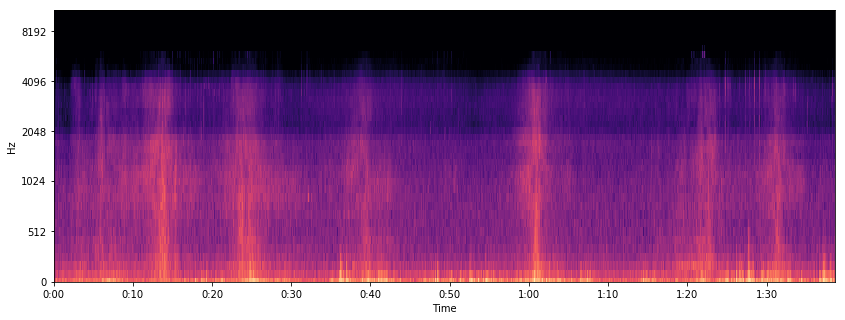

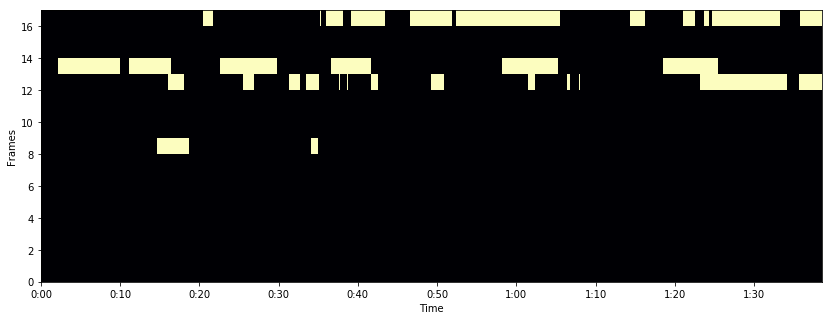

In [69]:
# plt.figure(figsize=(14, 5))
# librosa.display.waveplot(resampled_waveform, sr= sample_rate)
# plt.show()

plt.figure(figsize=(14, 5))
librosa.display.specshow(mbe.T,sr=new_sample_rate,
                        x_axis='time', y_axis='mel')
plt.show()

plt.figure(figsize=(14, 5))
librosa.display.specshow(label.T,sr=new_sample_rate,
                        x_axis='time', y_axis='frames')
plt.show()

# 5. Load & Normalize all data & labels

For each fold, do: 

* load train & evaluate files

* read these description files

* for each audio files (keys in dict):

    - load audio waves
    
    - load label
    
    - synchronize labels along with audio waves
    
    - normalize data by StandardScaler (or sth else)
    
    - save them in a file for later reuse
 

In [6]:
# def extract_mbe_features(filename, dataset_path, sr):
#     waveform, sample_rate = librosa.load(dataset_path + filename,mono=True)
#     if sample_rate != sr:
#         waveform = librosa.core.resample(waveform, sample_rate, sr)
#     ## extract mel band energie
#     n_fft = 2048
#     n_mels = 40
#     spec, _ = librosa.core.spectrum._spectrogram(y = waveform, n_fft =  n_fft, hop_length=int(n_fft/2), power=1)
#     mel_basis = librosa.filters.mel(sr=sr, n_fft = n_fft, n_mels=n_mels)
#     log_mel = np.log(np.dot(mel_basis, spec))
#     mbe = log_mel.T
#     return waveform, mbe

In [4]:
desc_dict = load_desc(dataset_path + 'meta.txt')

In [5]:
print(desc_dict.keys())

dict_keys(['audio/residential_area/a002.wav', 'audio/residential_area/a012.wav', 'audio/residential_area/a001.wav', 'audio/home/a030.wav', 'audio/home/b032.wav', 'audio/residential_area/b007.wav', 'audio/residential_area/b002.wav', 'audio/residential_area/a011.wav', 'audio/home/b033.wav', 'audio/home/a034.wav', 'audio/home/a036.wav', 'audio/residential_area/a013.wav', 'audio/residential_area/a010.wav', 'audio/home/a031.wav', 'audio/residential_area/b004.wav', 'audio/home/b044.wav', 'audio/home/a038.wav', 'audio/residential_area/a003.wav', 'audio/residential_area/b003.wav', 'audio/residential_area/b009.wav', 'audio/home/b029.wav', 'audio/home/b030.wav'])


In [6]:
feature_folder = dataset_path + "features/"
if not os.path.exists(feature_folder):
    os.makedirs(feature_folder)

In [7]:
# ### Extract and save (features, labels) for these videos
# n_fft = 2048
# hop_len = int(n_fft/2)
# new_sample_rate = 44100

# for audio_fn in tqdm.notebook.tqdm(desc_dict.keys(), total=len(desc_dict)):
#     mbe =extract_audio_features(audio_fn)
#     label = np.zeros((mbe.shape[0], len(__class_labels)))
#     tmp_data = np.array(desc_dict[filename])
#     frame_start = np.floor(tmp_data[:,0] * new_sample_rate / hop_len).astype(int)
#     frame_end = np.ceil(tmp_data[:,1] * new_sample_rate / hop_len).astype(int)
#     se_class = tmp_data[:,2].astype(int)
#     for ind, val in enumerate(se_class):
#         label[frame_start[ind]:frame_end[ind], val] = 1
#     tmp_feature_file = os.path.join(feature_folder, '{}.npz'.format(audio_fn.split('/')[-1]))
#     np.savez(tmp_feature_file, mbe, label)

# 6. Take a fold then load (features, labels)

In [8]:
fold = 1
scenes = ['home', 'residential_area']
# scenes = ['residential_area']
train_files = [os.path.join(dataset_path + "evaluation_setup/{}_fold{}_train.txt".format(scene, fold)) 
                   for scene in scenes]
eval_files = [os.path.join(dataset_path + "evaluation_setup/{}_fold{}_evaluate.txt".format(scene, fold)) 
                   for scene in scenes]

In [9]:
train_dict, eval_dict = {}, {}
for file in train_files:
    print("Loading labels from", file)
    train_dict.update(load_desc(file))
    print(len(train_dict))

for file in eval_files:
    print("Loading labels from", file)
    eval_dict.update(load_desc(file))
    print(len(eval_dict))

Loading labels from /home/renault/Projects/Statet-of-the-Art/Dataset/TUT-SED-2016/evaluation_setup/home_fold1_train.txt
7
Loading labels from /home/renault/Projects/Statet-of-the-Art/Dataset/TUT-SED-2016/evaluation_setup/residential_area_fold1_train.txt
16
Loading labels from /home/renault/Projects/Statet-of-the-Art/Dataset/TUT-SED-2016/evaluation_setup/home_fold1_evaluate.txt
3
Loading labels from /home/renault/Projects/Statet-of-the-Art/Dataset/TUT-SED-2016/evaluation_setup/residential_area_fold1_evaluate.txt
6


In [10]:
print(train_dict.keys())
print(eval_dict.keys())

dict_keys(['audio/residential_area/a002.wav', 'audio/residential_area/a012.wav', 'audio/home/a030.wav', 'audio/residential_area/b007.wav', 'audio/residential_area/b002.wav', 'audio/residential_area/a011.wav', 'audio/home/b029.wav', 'audio/home/a034.wav', 'audio/home/a036.wav', 'audio/residential_area/a013.wav', 'audio/home/a031.wav', 'audio/residential_area/b004.wav', 'audio/residential_area/a003.wav', 'audio/residential_area/b009.wav', 'audio/home/b033.wav', 'audio/home/b030.wav'])
dict_keys(['audio/home/b044.wav', 'audio/home/a038.wav', 'audio/home/b032.wav', 'audio/residential_area/b003.wav', 'audio/residential_area/a001.wav', 'audio/residential_area/a010.wav'])


In [11]:
def plot_features(mbe,label):
    plt.figure(figsize=(14, 5))
    librosa.display.specshow(mbe.T,sr=new_sample_rate, hop_length=hop_len,
                            x_axis='time', y_axis='mel')
    plt.show()

    plt.figure(figsize=(14, 5))
    librosa.display.specshow(label.T,sr=new_sample_rate, hop_length=hop_len,
                            x_axis='time', y_axis='frames')
    plt.show()  
    return 0

In [12]:
# a_demo_file = list(train_dict.keys())[0]
# feature_file = os.path.join(feature_folder + '{}.npz'.format(a_demo_file))
# dmp = np.load(feature_file)
# mbe, label = dmp['arr_0'], dmp['arr_1']

# plt.figure(figsize=(14, 5))
# librosa.display.specshow(mbe.T,sr=new_sample_rate,
#                         x_axis='time', y_axis='mel')
# plt.show()

# plt.figure(figsize=(14, 5))
# librosa.display.specshow(label.T,sr=new_sample_rate,
#                         x_axis='time', y_axis='frames')
# plt.show()

In [13]:
X_train, Y_train = None, None
for train_key in train_dict.keys():
    feature_file = os.path.join(feature_folder + '{}.npz'.format(train_key.split("/")[-1]))
    dmp = np.load(feature_file)
    mbe, label = dmp['arr_0'], dmp['arr_1']
    print(train_key, ": feature_shape =", mbe.shape, ", label_shape =",label.shape)
    if X_train is None: 
        X_train, Y_train = mbe, label
    else:
        X_train, Y_train = np.concatenate((X_train,mbe),axis=0), np.concatenate((Y_train, label))
print(np.asarray(X_train).shape)
print(np.asarray(Y_train).shape)

audio/residential_area/a002.wav : feature_shape = (7927, 40) , label_shape = (7927, 17)
audio/residential_area/a012.wav : feature_shape = (9262, 40) , label_shape = (9262, 17)
audio/home/a030.wav : feature_shape = (7818, 40) , label_shape = (7818, 17)
audio/residential_area/b007.wav : feature_shape = (9347, 40) , label_shape = (9347, 17)
audio/residential_area/b002.wav : feature_shape = (8493, 40) , label_shape = (8493, 17)
audio/residential_area/a011.wav : feature_shape = (9297, 40) , label_shape = (9297, 17)
audio/home/b029.wav : feature_shape = (10439, 40) , label_shape = (10439, 17)
audio/home/a034.wav : feature_shape = (7805, 40) , label_shape = (7805, 17)
audio/home/a036.wav : feature_shape = (7844, 40) , label_shape = (7844, 17)
audio/residential_area/a013.wav : feature_shape = (9680, 40) , label_shape = (9680, 17)
audio/home/a031.wav : feature_shape = (7779, 40) , label_shape = (7779, 17)
audio/residential_area/b004.wav : feature_shape = (6726, 40) , label_shape = (6726, 17)
au

In [14]:
X_eval, Y_eval = None,None
for eval_key in eval_dict.keys():
    feature_file = os.path.join(feature_folder + '{}.npz'.format(eval_key.split("/")[-1]))
    dmp = np.load(feature_file)
    mbe, label = dmp['arr_0'], dmp['arr_1']
    print(eval_key, ": feature_shape =", mbe.shape, ", label_shape =",label.shape)
    if X_eval is None: 
        X_eval, Y_eval = mbe, label
    else:
        X_eval, Y_eval = np.concatenate((X_eval,mbe),axis=0), np.concatenate((Y_eval, label))
print(np.asarray(X_eval).shape)
print(np.asarray(Y_eval).shape)

audio/home/b044.wav : feature_shape = (7844, 40) , label_shape = (7844, 17)
audio/home/a038.wav : feature_shape = (7800, 40) , label_shape = (7800, 17)
audio/home/b032.wav : feature_shape = (12956, 40) , label_shape = (12956, 17)
audio/residential_area/b003.wav : feature_shape = (10133, 40) , label_shape = (10133, 17)
audio/residential_area/a001.wav : feature_shape = (7891, 40) , label_shape = (7891, 17)
audio/residential_area/a010.wav : feature_shape = (9084, 40) , label_shape = (9084, 17)
(55708, 40)
(55708, 17)


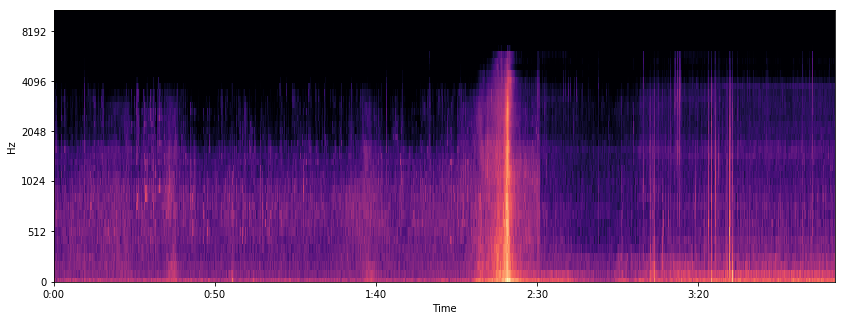

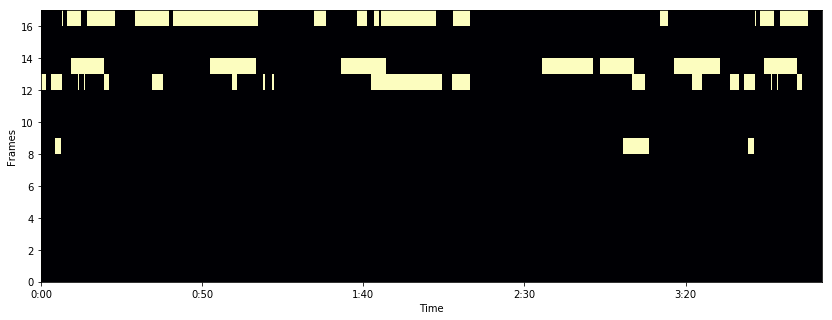

0

In [15]:
plot_features(X_train[10677:10677+10439,:] , Y_train[10677:10677+10439,:])

In [16]:
### Normalize the training data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_eval = scaler.transform(X_eval)

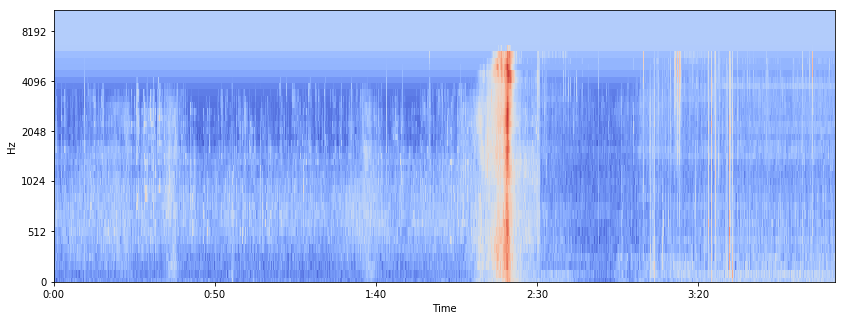

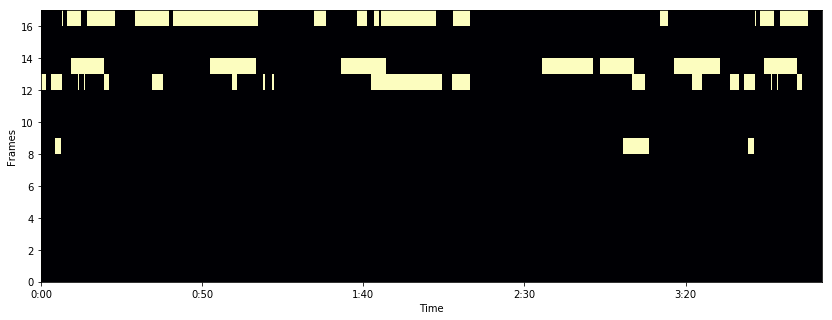

0

In [17]:
plot_features(X_train[10677:10677+10439,:] , Y_train[10677:10677+10439,:])

# 7. Preprocessing : Splitting in sequences

In [18]:
print(X_train.shape)
print(Y_train.shape)
print(X_eval.shape)
print(Y_eval.shape)

(146529, 40)
(146529, 17)
(55708, 40)
(55708, 17)


In [18]:
def split_in_seqs(data,subdivs,expand_dims = True):
    if data.shape[0] % subdivs : 
        ## cut the tail of array
        data = data[:-(data.shape[0]%subdivs),:]
    data = data.reshape((-1, subdivs, data.shape[1]))
    if expand_dims : 
        return np.expand_dims(data,1)
    else:
        return data

In [19]:
seq_len = 256
X_train = split_in_seqs(X_train,seq_len)
Y_train = split_in_seqs(Y_train,seq_len)
X_eval  = split_in_seqs(X_eval,seq_len)
Y_eval  = split_in_seqs(Y_eval,seq_len)
print(X_train.shape)
print(Y_train.shape)
print(X_eval.shape)
print(Y_eval.shape)

(572, 1, 256, 40)
(572, 1, 256, 17)
(217, 1, 256, 40)
(217, 1, 256, 17)


# 8. Build model

In [55]:
class TimeDistributed(Module):
    def __init__(self, module, batch_first=False):
        super(TimeDistributed, self).__init__()
        self.module = module
        self.batch_first = batch_first

    def forward(self, x):

        if len(x.size()) <= 2:
            return self.module(x)

        # Squash samples and timesteps into a single axis
        x_reshape = x.contiguous().view(-1, x.size(-1))  # (samples * timesteps, input_size)

        y = self.module(x_reshape)

        # We have to reshape Y
        if self.batch_first:
            y = y.contiguous().view(x.size(0), -1, y.size(-1))  # (samples, timesteps, output_size)
        else:
            y = y.view(-1, x.size(1), y.size(-1))  # (timesteps, samples, output_size)

        return y

class BidirectionalGRU(Module):

    def __init__(self, nIn, nHidden, nOut):
        super(BidirectionalGRU, self).__init__()

        self.rnn = GRU(nIn, nHidden, bidirectional=True)
        self.embedding = Linear(nHidden * 2, nOut)
        self.tanh = Tanh()
        
    def forward(self, input):
        recurrent, _ = self.rnn(input)
        recurrent = self.tanh(recurrent)
        T, b, h = recurrent.size()
        t_rec = recurrent.view(T * b, h)
        
        output = self.tanh(self.embedding(t_rec))  # [T * b, nOut]
        output = output.view(T, b, -1)
        return output
    

class SED_Net(Module):
    
    def __init__(self):
        super(SED_Net,self).__init__()
        
        self.cnn_bloc_1 = Sequential(
            ## First conv bloc
            Conv2d(in_channels=1, out_channels=96, kernel_size=(3,3), padding=(1,1)),
            BatchNorm2d(num_features=96),
            ReLU(),
            MaxPool2d(kernel_size=(1,2)),
            Dropout(0.25)
        )
        
        self.cnn_bloc_2 = Sequential(
            ## second conv bloc
            Conv2d(in_channels=96,out_channels=96, kernel_size=(3,3), padding=(1,1)),
            BatchNorm2d(num_features=96),
            ReLU(),
            MaxPool2d(kernel_size=(1,2)),
            Dropout(0.25)
        )
        
        self.rnn = Sequential(
            BidirectionalGRU(96*5,96,96),
            Dropout(0.25),
            BidirectionalGRU(96,96,96),
            Dropout(0.25),
            BidirectionalGRU(96,96,17)
        )
        
#         self.rnn_bloc_1= GRU(input_size=96*5, hidden_size=96, bidirectional = True, batch_first=True, num_layers=2, dropout=0.5)
        
#         self.rnn_bloc_2= GRU(input_size=96*2, hidden_size=96, bidirectional = True, batch_first=True, num_layers=2, dropout=0.5)
        
#         self.time_distributed = TimeDistributed(Linear(192,17))
#         self.linear_layers = Sequential(
#             Linear(in_features = 17, out_features = 17)
#         )
    
    def forward(self,x):
#         print(x.size())
        x = self.cnn_bloc_1(x)
#         print(x.size())
        x = self.cnn_bloc_2(x)
#         print(x.size())
        x = self.cnn_bloc_2(x) ## batch_size, channels, seq_len, feature_width
#         print(x.size())
        x = x.permute(2,0,1,3) ## seq_len, batch_size, channels, feature_width
#         print(cnn.size())
        seq_len, b, c, f = x.size()
        x = x.contiguous().view(seq_len, b, c*f) ## seq_len, batch_size, (channels*feature_width) 
#         print(x.size())
        
        x = self.rnn(x) ## seq_len, batchsize, classes
        x = x.contiguous().view(b,seq_len,17)
#         h0 = torch.from_numpy(np.zeros((4, x.size(0), 96))).float()
        
#         x,_ = self.rnn_bloc_1(x,h0)
#         print(x.size())

#         x,_ = self.rnn_bloc_2(x,h0)
#         print(x.size())

#         x = self.time_distributed(x)
#         print(x.size())
#         x = Linear(17,17)(x)
#         x = LogSoftmax(dim=2)(x)
#         x = self.linear_layers(x)
        
#         x = F.log_softmax(x)
        return x

# def custom_loss_function(output, target):
#     class_loss = BCELoss()
#     loss = []
#     for i_class in range(target.size(-1)):
#         output_i = output[:,:,i_class].view(-1).float().requires_grad_()
#         target_i = target[:,:,i_class].view(-1).float()
# #         print(output_i.size(), target_i.size())
        
#         loss.append(class_loss(output_i, target_i).item())
#     loss = np.array([np.sum(loss)])
#     loss = torch.from_numpy(loss)
#     loss = Variable(loss, requires_grad = True)
#     return loss

sed_model = SED_Net()
print(sed_model)

# ## Define loss function an optimizer
# # criterion = NLLLoss()
# # criterion = CrossEntropyLoss()
# criterion = CTCLoss()
criterion = BCEWithLogitsLoss()
optimizer = Adam(sed_model.parameters(), lr=0.0001, weight_decay=1e-5)

SED_Net(
  (cnn_bloc_1): Sequential(
    (0): Conv2d(1, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.25, inplace=False)
  )
  (cnn_bloc_2): Sequential(
    (0): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.25, inplace=False)
  )
  (rnn): Sequential(
    (0): BidirectionalGRU(
      (rnn): GRU(480, 96, bidirectional=True)
      (embedding): Linear(in_features=192, out_features=96, bias=True)
      (tanh): Tanh()
    )
    (1): Dropout(p=0.25, inplace=False)
    (2): BidirectionalGRU(
      (rnn): GRU(96, 96, bidirectional=Tr

In [24]:
X_train.shape

(572, 1, 256, 40)

In [40]:
data = torch.from_numpy(np.expand_dims(X_train[0,:,:,:],0))
data.size()

torch.Size([1, 1, 256, 40])

In [41]:
writer = SummaryWriter('runs/sed_crnn_test_3')
writer.add_graph(sed_model, data)

# 9. Train model

In [21]:
def shuffling(X,Y):
    indx = np.arange(len(X))
    np.random.shuffle(indx)
    return X[indx], Y[indx]

# print(X_eval[0])
# print(shuffling(X_eval)[0])

In [ ]:
## Train model

# print("Adding model to tensorboard")
# sample_batched = next(train_dataloader)
# data, label = sample_batched['raw_signal'], sample_batched['label']
# writer.add_graph(conv1d_model, data)

# model_added =  False 
num_epochs = 50
n_iter = 0
best_acc_loss = np.inf
checkpoint = len(X_train)

print("Start training...")
for epoch in range(num_epochs):
    train_losses = []
    train_accs = []
    val_losses = []
    val_accs  = []
#     f1_overall_1sec = []
#     er_overall_1sec = []
#     val_f1_overall_1sec = []
#     val_er_overall_1sec = []
    f1_overall_fr= []
    er_overall_fr= []
    val_f1_overall_fr = []
    val_er_overall_fr = []
#     train_iter  = iter(train_dataloader)
#     val_iter  = iter(val_dataloader)
    
    print('Epoch %d/%d :' %(epoch +1, num_epochs))
#     print('[Training phase] : ', end='')
    
    X_train, Y_train = shuffling(X_train, Y_train)
    X_eval, Y_eval = shuffling(X_eval, Y_eval)
    
    for i_batch, data in tqdm.notebook.tqdm(enumerate(X_train), total=len(X_train)):
#         sample_batched = next(train_iter)
        n_iter += 1
        data = torch.from_numpy(np.expand_dims(data,axis=0))
#         print(Y_train[i_batch,:,:].shape)
        label = torch.from_numpy(Y_train[i_batch,:,:,:])
#         print(label.size())
        
        if label.detach().numpy().sum() == 0:
            continue
            
#         print("do")
        ## forward + backward + optimize
        outputs = sed_model(data) #.squeeze()
#         print(outputs.size())
#         loss = custom_loss_function(outputs, label)
#         input_lengths = torch.full(size=(1,), fill_value=256, dtype=torch.long)
#         target_lengths = torch.full(size=(1,), fill_value=256, dtype=torch.long)      
#         loss = criterion(outputs,label, 
#                          input_lengths,
#                          target_lengths)

#         _, y_pred = torch.max(F.sigmoid(outputs, dim=2),1)
# #         _, y_pred = torch.max(outputs.data,1)

# #         print(y_pred, "vs ",label)
#         correct = (y_pred == label).sum().item()
#         running_acc = correct/label.size(0)
        y_pred = torch.sigmoid(outputs) 
        y_pred_thresh = (y_pred.detach().numpy() > 0.5).astype(int)
#         print(y_pred_thresh)
#         print(label)
#         print(y_pred.size())
#         print(y_pred_thresh.size())
#         score_list = sed_metrics.compute_scores(y_pred_thresh.detach().numpy(),
#                                                 label.detach().numpy(), 
#                                                 frames_in_1_sec=frames_1_sec)
            
#         f1_overall_1sec.append(score_list['f1_overall_1sec'])
#         er_overall_1sec.append(score_list['er_overall_1sec'])
        f1_overall_fr.append(sed_metrics.f1_overall_framewise(y_pred_thresh,
                                                        label.detach().numpy()))
        er_overall_fr.append(sed_metrics.er_overall_framewise(y_pred_thresh,
                                                        label.detach().numpy()))
        
        
        loss = criterion(outputs,label)
        loss = torch.add(loss, sed_metrics.er_overall_framewise(y_pred_thresh,
                                                        label.detach().numpy())) * 0.5
#         print(loss)
#         with autograd.detect_anomaly():
        loss.backward()
#         conv2d_model.float()
#         torch.nn.utils.clip_grad_norm_(conv2d_model.parameters(),0.5)

        optimizer.step()
        optimizer.zero_grad()
        
        ## compute statistics
        running_loss = loss.item()
        
        train_losses.append(running_loss)
#         train_accs.append(running_acc)
        
#         sys.stdout.write("\rcurrent_train_loss = %.5f, current_train_acc = %.5f" 
#                          % (np.mean(train_losses), np.mean(train_accs)))

        sys.stdout.write("\rtrain_loss = %.5f, f1 = %.5f, er = %.5f" 
                         % (np.mean(train_losses), np.mean(f1_overall_fr), np.mean(er_overall_fr)))
        sys.stdout.flush()

        #=======================
        # print every a number n iterations + validate model
        #=======================        
        if n_iter % checkpoint == 0:
            train_loss = np.mean(train_losses)
#             train_acc = np.mean(train_accs)
        
            writer.add_scalar('train/loss', train_loss, n_iter)
#             writer.add_scalar('train/acc', train_acc, n_iter)
                    
            ## valid model
#             print("[Validating phase] :", end ='')
            print('\nValidating...')
            sed_model.eval()
            with torch.no_grad():

                for id_val_batch, val_data in enumerate(X_eval):
        #             val_batched = next(val_iter)
#                     val_data, val_label = val_batched['features'], val_batched['label']
#                     conv1d_model.eval()
                    val_data = torch.from_numpy(np.expand_dims(val_data,axis=0))
                    val_label = torch.from_numpy(Y_eval[id_val_batch,:,:,:])
        
                    if val_label.detach().numpy().sum() == 0:
                        continue
                    val_outputs = sed_model(val_data)
#                     val_loss = custom_loss_function(val_outputs, val_label).item()
                    val_loss = criterion(val_outputs, val_label).item()
#                     _, val_pred = torch.max(F.softmax(val_outputs, dim=1),1)
#                     _, val_pred = torch.max(val_outputs.data, 1)
#                     val_correct = (val_pred == val_label).sum().item()
#                     val_acc = val_correct / val_label.size(0)

#                     sys.stdout.write("\r val_loss = %.5f,  val_acc = %.5f" % (val_loss, val_acc))
#                     sys.stdout.flush()

                    y_pred = torch.sigmoid(val_outputs) 
                    y_pred_thresh = (y_pred.detach().numpy() > 0.5).astype(int)
#                     score_list = sed_metrics.compute_scores(y_pred_thresh.detach().numpy(), 
#                                                             val_label.detach().numpy(), 
#                                                             frames_in_1_sec=frames_1_sec)
#                     val_f1_overall_1sec.append(score_list['f1_overall_1sec'])
#                     val_er_overall_1sec.append(score_list['er_overall_1sec'])
                    val_f1_overall_fr.append(sed_metrics.f1_overall_framewise(y_pred_thresh,
                                                        val_label.detach().numpy()))
                    val_er_overall_fr.append(sed_metrics.er_overall_framewise(y_pred_thresh,
                                                        val_label.detach().numpy()))

                    val_losses.append(val_loss)
#                     val_accs.append(val_acc)

                    
                
            val_loss = np.mean(val_losses)
#             val_acc  = np.mean(val_accs)
#             print('val_loss = %.5f, val_acc = %.5f' % (val_loss, val_acc))
            writer.add_scalar('val/loss', val_loss, n_iter)
#             writer.add_scalar('val/acc', val_acc, n_iter)

#             print("val_loss = %.5f, val_acc = %.5f\n" 
#                              % (val_loss, val_acc))
            print("val_loss = %.5f, val_f1 = %.5f, val_er = %.5f" 
                         % (np.mean(val_losses), np.mean(val_f1_overall_fr), np.mean(val_er_overall_fr)))
#             sys.stdout.flush()
            if val_loss < best_acc_loss : 
                best_acc_loss = val_loss
                sys.stdout.write("Saving model...\n")
                torch.save(sed_model, 'sed_test.pt')
                
            sed_model.train()
            train_losses = []
#             train_accs = []
            val_losses = []
#             val_accs  = []
#             f1_overall_1sec = []
#             er_overall_1sec = []
#             val_f1_overall_1sec = []
#             val_er_overall_1sec = [] 
            f1_overall_fr = []
            er_overall_fr = []
            val_f1_overall_fr = []
            val_er_overall_fr = []   
#     writer.add_scalar('train/loss', train_loss, epoch)
#     writer.add_scalar('train/acc', train_acc, epoch)
#     writer.add_scalar('val/loss', val_loss, epoch)
#     writer.add_scalar('val/acc', val_acc, epoch)
    
    print("=" * 80 )
    
print("Finish training.")
writer.close()

Start training...
Epoch 1/50 :


train_loss = 0.73248, f1 = 0.00662, er = 1.05998

In [50]:
# for param in sed_model.parameters():
#     print(type(param.data), param.size())
pytorch_total_params = sum(p.numel() for p in sed_model.parameters())
pytorch_total_params

681137

In [25]:
a = np.array([[1,2],[3,4]])
a

array([[1, 2],
       [3, 4]])

In [26]:
np.max(a,axis=0)

array([3, 4])

In [ ]:
a.sum()

In [20]:
# eps = np.finfo(np.float).eps
# eps

2.220446049250313e-16

# 10. Predict results



In [18]:
model_path = "sed_test.pt"
print('loading pretrained model from %s' % model_path)
load_sed_model = torch.load(model_path)
load_sed_model.eval()

loading pretrained model from sed_test.pt


SED_Net(
  (cnn_bloc_1): Sequential(
    (0): Conv2d(1, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (cnn_bloc_2): Sequential(
    (0): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (rnn): Sequential(
    (0): BidirectionalGRU(
      (rnn): GRU(480, 96, bidirectional=True)
      (embedding): Linear(in_features=192, out_features=96, bias=True)
      (tanh): Tanh()
    )
    (1): BidirectionalGRU(
      (rnn): GRU(96, 96, bidirectional=True)
      (embedding): Linear(in_features=192, out_features=17, bias=True)
      (tanh): Tanh()
    )
  )
)

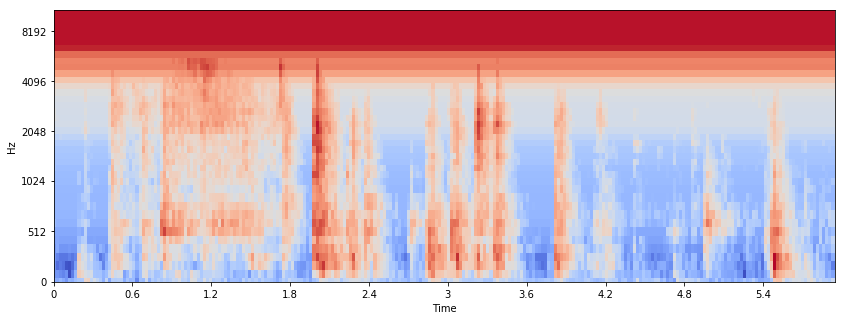

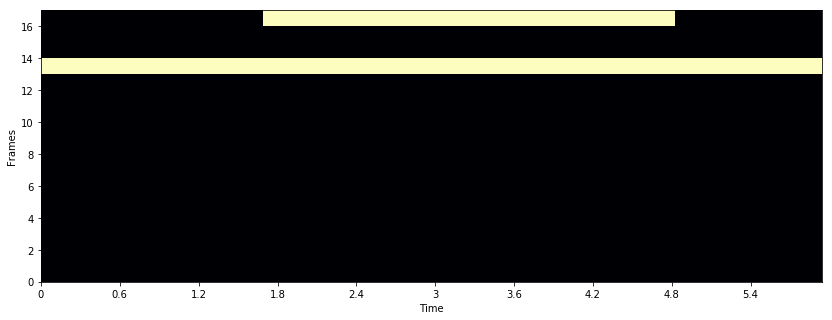

0

In [19]:
id_val_batch = 27

plot_features(X_eval[id_val_batch,0,:,:], Y_eval[id_val_batch,0,:,:])

In [20]:
val_data = X_eval[id_val_batch]
print(val_data.shape)
val_data = torch.from_numpy(np.expand_dims(val_data,axis=0))
val_label = torch.from_numpy(Y_eval[id_val_batch,:,:,:])
val_outputs = load_sed_model(val_data).squeeze()

val_outputs = torch.sigmoid(val_outputs)
# print(val_outputs.shape)
# # print(val_outputs)
# # val_pred = F.threshold(val_outputs, 0.2, 1)
# val_pred = torch.zeros(size=val_outputs.size())
# for i in range(val_outputs.size(0)):
#     for j in range(val_outputs.size(1)):
#         if val_outputs[i,j] > 0.5:
#             val_pred[i,j] = 1

y_pred = torch.sigmoid(val_outputs) 
y_pred_thresh = y_pred > 0.5
print(y_pred.size())
print(y_pred_thresh.size())
score_list = sed_metrics.compute_scores(y_pred_thresh.detach().numpy(), val_label.detach().numpy()[0], frames_in_1_sec=frames_1_sec)
f1_overall_1sec = score_list['f1_overall_1sec']
er_overall_1sec = score_list['er_overall_1sec']
print(f1_overall_1sec)
print(er_overall_1sec)

# pred = val_pred.detach().numpy()
# print(pred)
# real = val_label.detach().numpy()
# val_data = val_data.detach().numpy()

# print(val_data[0][0].shape)
# print(pred.shape)
# print(real[0].shape)

(1, 256, 40)
torch.Size([256, 17])
torch.Size([256, 17])
0.17857142857142852
8.444444444444445


In [32]:
# def f1_overall_framewise(O, T):
#     eps = np.finfo(np.float).eps
#     if len(O.shape) == 3:
#         O, T = utils.reshape_3Dto2D(O), utils.reshape_3Dto2D(T)
#     TP = ((2 * T - O) == 1).sum()
#     Nref, Nsys = T.sum(), O.sum()

#     prec = float(TP) / float(Nsys + eps)
#     recall = float(TP) / float(Nref + eps)
#     f1_score = 2 * prec * recall / (prec + recall + eps)
#     return f1_score

# def f1_overall_1sec(O, T, block_size):
#     if len(O.shape) == 3:
#         O, T = utils.reshape_3Dto2D(O), utils.reshape_3Dto2D(T)
#     print(T.shape)
#     new_size = int(np.ceil(O.shape[0] / block_size))
#     print(new_size)
#     O_block = np.zeros((new_size, O.shape[1]))
#     T_block = np.zeros((new_size, O.shape[1]))
#     print(T_block.shape)
#     for i in range(0, new_size):
#         O_block[i, :] = np.max(O[int(i * block_size):int(i * block_size + block_size - 1), ], axis=0)
#         T_block[i, :] = np.max(T[int(i * block_size):int(i * block_size + block_size - 1), ], axis=0)
#     return f1_overall_framewise(O_block, T_block)

# f1_overall_1sec(y_pred_thresh.detach().numpy(), val_label.detach().numpy()[0], block_size=frames_1_sec)

In [25]:
a = np.array([[1,2],[3,4]])
np.max(a,axis=1)

array([2, 4])

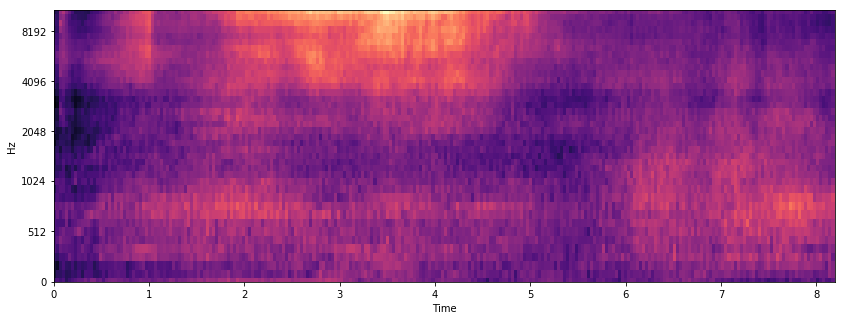

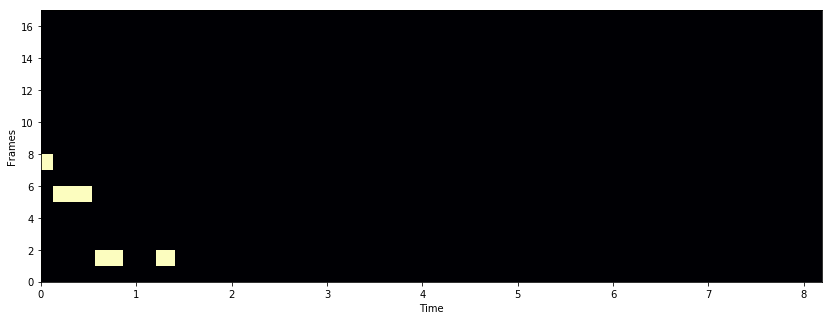

0

In [54]:
plot_features(val_data[0][0], real[0])

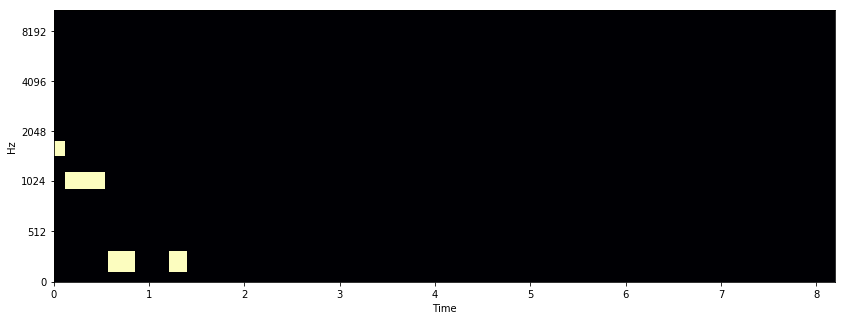

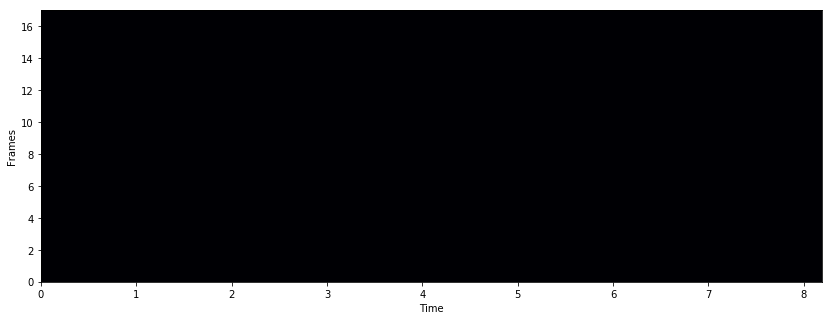

0

In [55]:
plot_features(real[0], pred)